In [38]:
%run 09_baseline_model.ipynb

In [39]:
import joblib
import pandas as pd

var = joblib.load('../cache/var_model.joblib')
dfm = joblib.load('../cache/dfm_model.joblib')
varmax = joblib.load('../cache/varmax_model.joblib')
naive = joblib.load('../cache/naive_model.joblib')

test_data = pd.read_parquet('../cache/test_data.parquet')
train_data = pd.read_parquet('../cache/train_data.parquet')
btc = pd.read_parquet('../cache/btc_cleaned.parquet')

In [40]:
# get results for the models
lag_order = var.k_ar
last_obs = train_data.values[-lag_order:]
naive_results = naive.forecast(steps=35039)
var_results = var.forecast(last_obs, steps=35039)
dfm_results = dfm.get_forecast(steps=35039)
varmax_results = varmax.forecast(steps=35039)

C:\Users\leo-mart\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\leo-mart\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\leo-mart\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [41]:
dfm_results_mean = dfm_results.predicted_mean

naive_df = pd.DataFrame(naive_results, columns=train_data.columns)
var_df = pd.DataFrame(var_results, columns=train_data.columns)
dfm_df = pd.DataFrame(dfm_results_mean, columns=train_data.columns)
varmax_df = pd.DataFrame(varmax_results, columns=train_data.columns)

In [42]:
var_df.head()
dfm_df.head()
varmax_df.head()

,Timestamp,Actor1Country,Actor1GeoCountry,Actor1Type,Actor2Country,Actor2GeoCountry,Actor2Type,ActionCountry,EventType,GoldsteinScale,NumSources,NumArticles,AvgTone,Magnitude,Impact,pct_change_30min
10000,1.165967,NaN,19.814492,8.856589,NaN,13.165950,10.874292,23.460156,-6.521625,NaN,NaN,NaN,NaN,-14.624744,1.224671,0.137775
10001,1.165077,NaN,11.974672,9.051145,NaN,10.703791,8.888771,9.842941,10.553419,NaN,NaN,NaN,NaN,0.579796,0.056872,0.157031
10002,1.165227,NaN,11.974970,9.051628,NaN,10.701237,8.888559,9.841836,10.549444,NaN,NaN,NaN,NaN,0.580371,0.056227,0.151269
10003,1.165232,NaN,11.974891,9.051635,NaN,10.701216,8.888546,9.841735,10.549539,NaN,NaN,NaN,NaN,0.580459,0.056230,0.151202
10004,1.165233,NaN,11.974888,9.051636,NaN,10.701215,8.888545,9.841731,10.549543,NaN,NaN,NaN,NaN,0.580462,0.056230,0.151202


In [43]:
naive_df.head()

,Timestamp,Actor1Country,Actor1GeoCountry,Actor1Type,Actor2Country,Actor2GeoCountry,Actor2Type,ActionCountry,EventType,GoldsteinScale,NumSources,NumArticles,AvgTone,Magnitude,Impact,pct_change_30min
1,1.170298,9,13,9,13,11,9,11,10,-0.104944,-0.677247,-0.106454,1.081663,-0.657705,0.034831,-0.018106
2,1.170298,9,13,9,13,11,9,11,10,-0.104944,-0.677247,-0.106454,1.081663,-0.657705,0.034831,-0.018106
3,1.170298,9,13,9,13,11,9,11,10,-0.104944,-0.677247,-0.106454,1.081663,-0.657705,0.034831,-0.018106
4,1.170298,9,13,9,13,11,9,11,10,-0.104944,-0.677247,-0.106454,1.081663,-0.657705,0.034831,-0.018106
5,1.170298,9,13,9,13,11,9,11,10,-0.104944,-0.677247,-0.106454,1.081663,-0.657705,0.034831,-0.018106


<Axes: ylabel='pct_change_30min'>

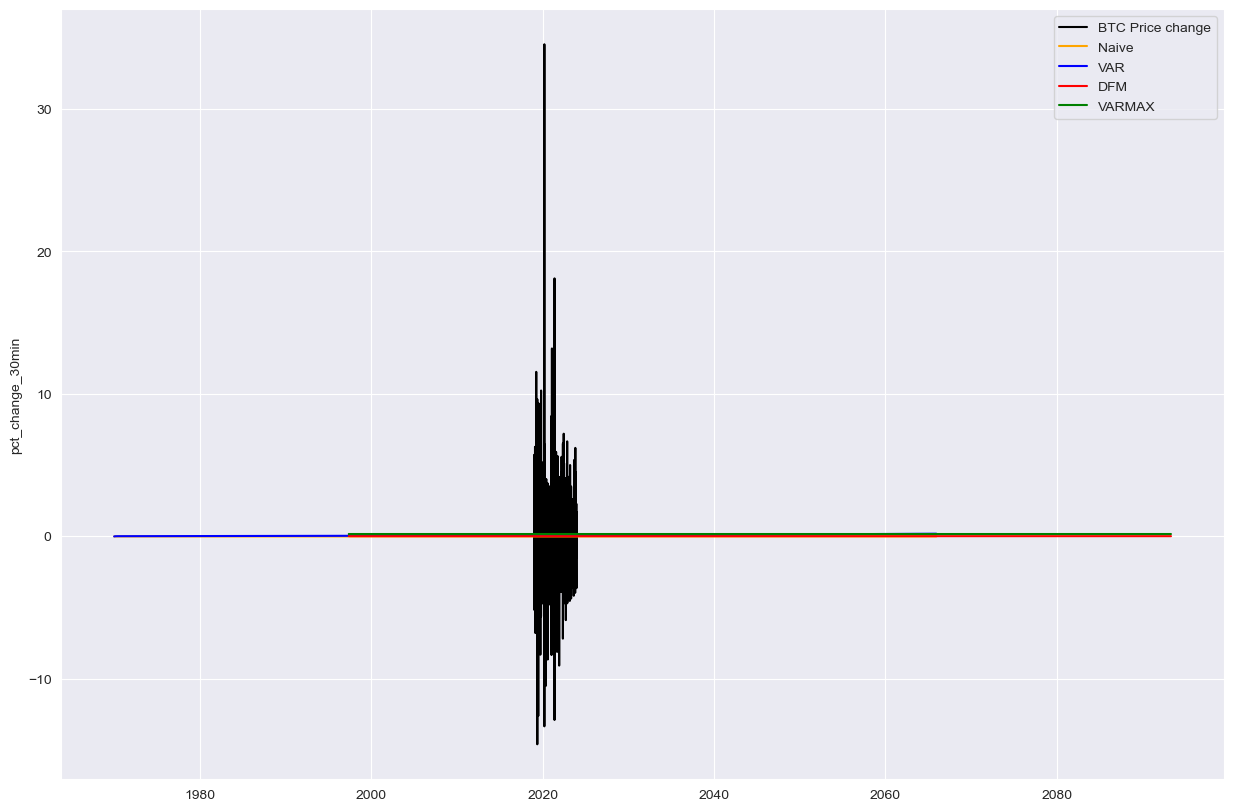

In [44]:
# plot btc 30min price and all the models
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=btc['pct_change_30min'], ax=ax, label='BTC Price change', color='black')
sns.lineplot(data=naive_df['pct_change_30min'], ax=ax, label='Naive', color='orange')
sns.lineplot(data=var_df['pct_change_30min'], ax=ax, label='VAR', color='blue')
sns.lineplot(data=dfm_df['pct_change_30min'], ax=ax, label='DFM', color='red')
sns.lineplot(data=varmax_df['pct_change_30min'], ax=ax, label='VARMAX', color='green')


In [54]:
# if pct_change_30min is negative then set it to 0, if pct_change_30min is positive then set it to 1
naive_signal = naive_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
var_signal = var_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
dfm_signal = dfm_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
varmax_signal = varmax_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
btc_signal = train_data['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)

In [56]:
money = 1000000
btc_prices = btc['pct_change_30min'].cumsum() + 1  # Convert percentage change to price index
btc_holdings = 0
portfolio_values = []

signals = [naive_signal, var_signal, dfm_signal, varmax_signal, btc_signal]
min_length = min(len(btc_prices), len(signals[0]))


# Naive model
for j in range(len(signals)):
    signal = signals[j]
    for i in range(min_length):
        current_price = btc_prices.iloc[i]
        if signal.iloc[i] == 1:
            # Buy 1 BTC
            money -= current_price
            btc_holdings += 1
        elif signal.iloc[i] == 0:
            # Sell 1 BTC
            money += current_price
            btc_holdings -= 1
        portfolio_value = money + btc_holdings * current_price
        portfolio_values.append(portfolio_value)
    print(portfolio_values[-1])

-250853.8008497171
905189.0552452889
2050280.0029054391
3301133.80375514
3168394.1316363625
